## Predict Boston Median House Prices Using XGBoost

In [2]:
% matplotlib inline

import os

import time
from time import gmtime, strftime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
import sklearn.model_selection

In [3]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

# This represents the sagemaker session
session = sagemaker.Session()

# This represents the IAM role we are currently assigned.
# We'll need it during training because we need to specify which IAM role the training job should have.
role = get_execution_role()

### Download the data

In [5]:
boston = load_boston()

### Prepare the data

In [9]:
X_boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)
Y_boston_df = pd.DataFrame(boston.target)

# Split into 2/3 training and 1/3 testing
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_boston_df, Y_boston_df, test_size=0.33)

# Split the training set further into 2/3 training and 1/3 validation
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

### Upload data files to S3

In [10]:
import tempfile
#import shutil

dirpath = tempfile.mkdtemp()

In [14]:
# Save the training, validation, and testing datasets to csv files.
# Do not include a header or an index, given the Amazon's XGBoost algorithm requires this to be the case.
# Also, for training and validation, the label should be the first column.
X_test.to_csv(os.path.join(dirpath, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(dirpath, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(dirpath, 'train.csv'), header=False, index=False)

In [16]:
prefix = 'boston-xgboost-sagemaker'

test_location = session.upload_data(os.path.join(dirpath, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(dirpath, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(dirpath, 'train.csv'), key_prefix=prefix)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-595374821637


### Construct and train the XGBoost model

In [17]:
# Get the name of the Docker container we're going to use for training.  There are different containers per
# region.
container = get_image_uri(session.boto_region_name, 'xgboost')

# Construct the training job parameters
training_params = {}

training_params['RoleArn'] = role

training_params['AlgorithmSpecification'] = {
    "TrainingImage": container,
    "TrainingInputMode": "File"
}

training_params['OutputDataConfig'] = {
    "S3OutputPath": "s3://" + session.default_bucket() + "/" + prefix + "/output"
}

training_params['ResourceConfig'] = {
    "InstanceCount": 1,
    "InstanceType": "ml.m4.xlarge",
    "VolumeSizeInGB": 5
}
    
training_params['StoppingCondition'] = {
    "MaxRuntimeInSeconds": 86400 # in case the job goes into an inifinite loop or something
}

training_params['HyperParameters'] = {
    "max_depth": "5",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.8",
    "objective": "reg:linear",
    "early_stopping_rounds": "10",
    "num_round": "200"
}

training_params['InputDataConfig'] = [
    {
        "ChannelName": "train",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": train_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",
        "CompressionType": "None"
    },
    {
        "ChannelName": "validation",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": val_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",
        "CompressionType": "None"
    }
]

In [18]:
# The training job name must be unique
training_job_name = "boston-xgboost-sagemaker" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
training_params['TrainingJobName'] = training_job_name

# Execute the training job.
training_job = session.sagemaker_client.create_training_job(**training_params)

In [19]:
# Wait until the training job has finished...
session.logs_for_job(training_job_name, wait=True)

2019-02-15 18:33:51 Starting - Launching requested ML instances......
2019-02-15 18:34:57 Starting - Preparing the instances for training......
2019-02-15 18:36:11 Downloading - Downloading input data...
2019-02-15 18:36:37 Training - Training image download completed. Training in progress.
2019-02-15 18:36:37 Uploading - Uploading generated training model
Arguments: train
[2019-02-15:18:36:32:INFO] Running standalone xgboost training.
[2019-02-15:18:36:32:INFO] File size need to be processed in the node: 0.03mb. Available memory size in the node: 8412.41mb
[2019-02-15:18:36:32:INFO] Determined delimiter of CSV input is ','
[18:36:32] S3DistributionType set as FullyReplicated
[18:36:32] 227x13 matrix with 2951 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-02-15:18:36:32:INFO] Determined delimiter of CSV input is ','
[18:36:32] S3DistributionType set as FullyReplicated
[18:36:32] 112x13 matrix with 1456 entries loaded from /opt/ml/input/data/va

In [20]:
# Use the model artifacts to build a model
training_job_info = session.sagemaker_client.describe_training_job(TrainingJobName=training_job_name)

model_artifacts = training_job_info['ModelArtifacts']['S3ModelArtifacts']

model_name = training_job_name + "-model"

primary_container = {
    "Image": container,
    "ModelDataUrl": model_artifacts
}

model_info = session.sagemaker_client.create_model(
                                ModelName = model_name,
                                ExecutionRoleArn = role,
                                PrimaryContainer = primary_container)

### Test the model

In [21]:
# Set up s batch transform job
transform_job_name = 'boston-xgboost-sagemaker-batch-transform-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# Now we construct the data structure which will describe the batch transform job.
transform_request = \
{
    "TransformJobName": transform_job_name,
    
    "ModelName": model_name,    
    
    "MaxConcurrentTransforms": 1,
    
    "MaxPayloadInMB": 6,
    
    "BatchStrategy": "MultiRecord",
    
    "TransformOutput": {
        "S3OutputPath": "s3://{}/{}/batch-bransform/".format(session.default_bucket(),prefix)
    },
    
    "TransformInput": {
        "ContentType": "text/csv",
        "SplitType": "Line",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": test_location,
            }
        }
    },

    "TransformResources": {
            "InstanceType": "ml.m4.xlarge",
            "InstanceCount": 1
    }
}

In [22]:
# Execute the batch transform job
transform_response = session.sagemaker_client.create_transform_job(**transform_request)
transform_desc = session.wait_for_transform_job(transform_job_name)

..............................................!


### Analyze the results

In [24]:
transform_output = "s3://{}/{}/batch-bransform/".format(session.default_bucket(),prefix)

In [25]:
!aws s3 cp --recursive $transform_output $dirpath

download: s3://sagemaker-us-east-1-595374821637/boston-xgboost-sagemaker/batch-bransform/test.csv.out to ../../../../../../tmp/tmp_7_yq0sk/test.csv.out


In [26]:
Y_pred = pd.read_csv(os.path.join(dirpath, 'test.csv.out'), header=None)

Text(0.5,1,'Median Price vs Predicted Price')

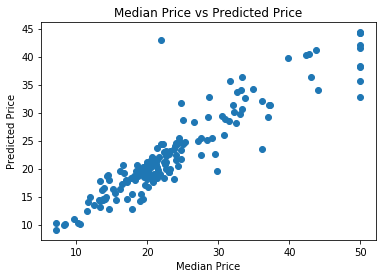

In [27]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

### Cleanup

In [29]:
import shutil
shutil.rmtree(dirpath)